try with series column and three classes and ['BallFault', 'InnerFault', 'outerFault'] and three features speed , series and vibration with accuracy of 86% with dropouts rows of same records in speed and vibration 


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv("../datasets/allfaultdatasetfiltered13.csv")
df.head() , df['class'].unique()

(      speed  vibration  series      class
 0  4.217042   0.003062       1  BallFault
 1  4.219672   0.004049       2  BallFault
 2  4.221645   0.001418       3  BallFault
 3  0.036346  -0.002199       4  BallFault
 4  0.036017  -0.003515       5  BallFault,
 array(['BallFault', 'InnerFault', 'outerFault'], dtype=object))

In [3]:
df.info

<bound method DataFrame.info of             speed  vibration   series       class
0        4.217042   0.003062        1   BallFault
1        4.219672   0.004049        2   BallFault
2        4.221645   0.001418        3   BallFault
3        0.036346  -0.002199        4   BallFault
4        0.036017  -0.003515        5   BallFault
...           ...        ...      ...         ...
5667608  4.202576  -0.004830  1889294  outerFault
5667609  4.198959  -0.003515  1889295  outerFault
5667610  4.279838  -0.002857  1889296  outerFault
5667611  0.037332  -0.006146  1889297  outerFault
5667612  0.037661  -0.009105  1889298  outerFault

[5667613 rows x 4 columns]>

In [4]:
df = df.drop_duplicates(subset = ["speed", 'vibration'])

print(df)

            speed  vibration   series       class
0        4.217042   0.003062        1   BallFault
1        4.219672   0.004049        2   BallFault
2        4.221645   0.001418        3   BallFault
3        0.036346  -0.002199        4   BallFault
4        0.036017  -0.003515        5   BallFault
...           ...        ...      ...         ...
5667456  4.151615  -0.016340  1889142  outerFault
5667459  2.739196  -0.009105  1889145  outerFault
5667542  3.131096  -0.001213  1889228  outerFault
5667560  1.329083  -0.000555  1889246  outerFault
5667578  0.155362   0.001747  1889264  outerFault

[757558 rows x 4 columns]


In [5]:
df['class'].unique()

array(['BallFault', 'InnerFault', 'outerFault'], dtype=object)

<AxesSubplot:xlabel='vibration', ylabel='count'>

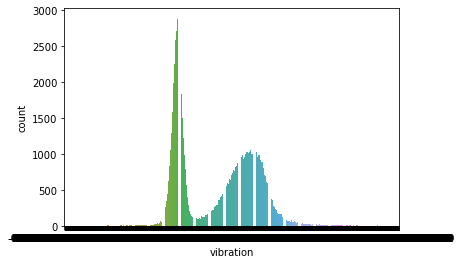

In [6]:
sns.countplot(x = 'vibration', data=df)

<AxesSubplot:>

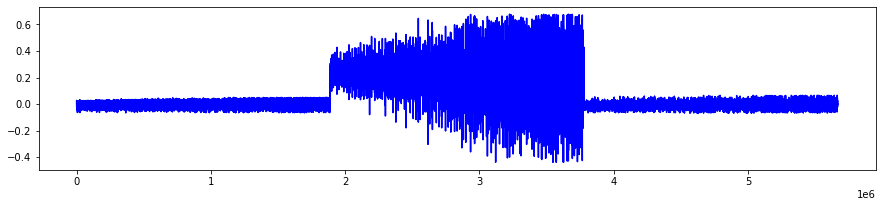

In [7]:
df['vibration'].plot(color='b',figsize = (15,3))

In [8]:
class2idx = {
    "BallFault":0,
    "InnerFault":1,
    "outerFault":2

}

idx2class = {v: k for k, v in class2idx.items()}

df['class'].replace(class2idx, inplace=True)
df['class'].unique()

C:\Users\bahma\.conda\envs\svm\lib\site-packages\pandas\core\series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


array([0, 1, 2], dtype=int64)

In [9]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X.head() , y.head()

(      speed  vibration  series
 0  4.217042   0.003062       1
 1  4.219672   0.004049       2
 2  4.221645   0.001418       3
 3  0.036346  -0.002199       4
 4  0.036017  -0.003515       5,
 0    0
 1    0
 2    0
 3    0
 4    0
 Name: class, dtype: int64)

In [10]:
y.unique() , len(y.unique())

(array([0, 1, 2], dtype=int64), 3)

In [11]:
# Split into train+val and test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

In [12]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [13]:
def get_class_distribution(obj):
    count_dict = {
        
        "BallFault" : 0,
        "InnerFault": 0,
        "outerFault": 0,
    }
    
    for i in obj:
        if i == 0: 
            count_dict['BallFault'] += 1
        elif i == 1: 
            count_dict['InnerFault'] += 1
        elif i == 2: 
            count_dict['outerFault'] += 1  
        else:
            print("Check classes.")
            
    return count_dict

Text(0.5, 1.0, 'Class Distribution in Test Set')

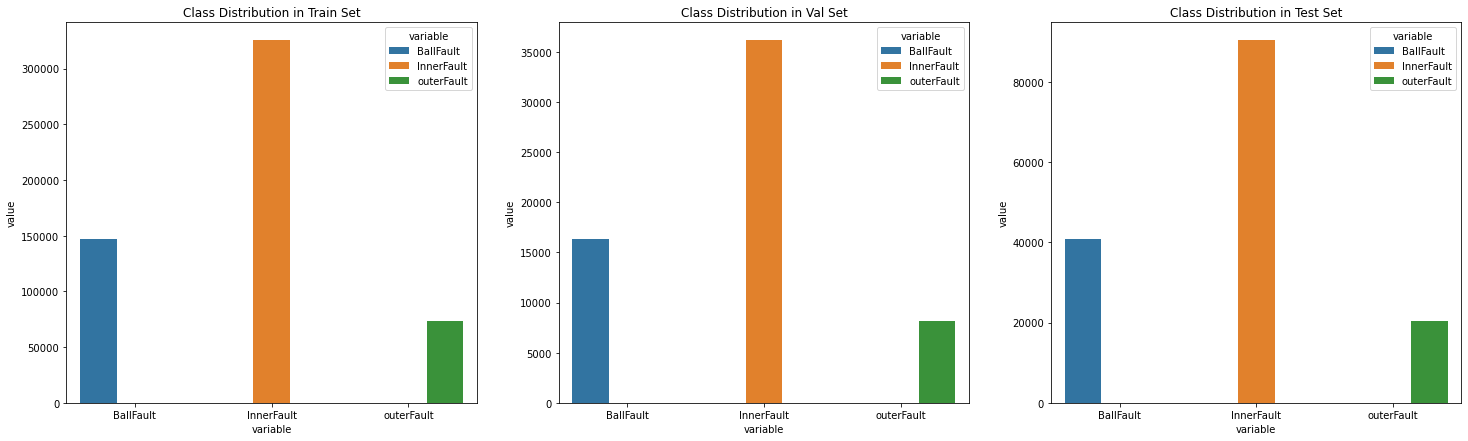

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')# Validation
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [15]:
class ClassifierDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_dataset = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
val_dataset = ClassifierDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [16]:
target_list = []
for _, t in train_dataset:
    target_list.append(t)
    
target_list = torch.tensor(target_list)
target_list = target_list[torch.randperm(len(target_list))]

In [17]:
class_count = [i for i in get_class_distribution(y_train).values()]
class_weights = 1./torch.tensor(class_count, dtype=torch.float) 
print(class_weights)


tensor([6.8112e-06, 3.0746e-06, 1.3628e-05])


In [18]:
class_weights_all = class_weights[target_list]

In [19]:
weighted_sampler = WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)

In [35]:
EPOCHS = 20
BATCH_SIZE = 100
LEARNING_RATE = 0.0007
NUM_FEATURES = len(X.columns)
NUM_CLASSES = len(y.unique())
NUM_FEATURES , NUM_CLASSES

(3, 3)

In [36]:
"""

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

https://discuss.pytorch.org/t/error-expected-more-than-1-value-per-channel-when-training/26274/4

You could set drop_last=True in your DataLoader and run your code again.
"""


train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,sampler=weighted_sampler , drop_last=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1, drop_last=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, drop_last=True)

In [37]:
class MulticlassClassification(nn.Module):
    def __init__(self, num_feature, num_class):
        super(MulticlassClassification, self).__init__()
        
        self.layer_1 = nn.Linear(num_feature, 512)
        self.layer_2 = nn.Linear(512, 128)
        self.layer_3 = nn.Linear(128, 64)
        self.layer_out = nn.Linear(64, num_class) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(64)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [38]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [39]:
model = MulticlassClassification(num_feature = NUM_FEATURES, num_class=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(model)


MulticlassClassification(
  (layer_1): Linear(in_features=3, out_features=512, bias=True)
  (layer_2): Linear(in_features=512, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=3, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [40]:
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

In [41]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [42]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = multi_acc(y_train_pred, y_train_batch)
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        val_epoch_acc = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = multi_acc(y_val_pred, y_val_batch)
            
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
            loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')


Begin training.


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 0.45198 | Val Loss: 0.26607 | Train Acc: 83.881| Val Acc: 84.981
Epoch 002: | Train Loss: 0.41045 | Val Loss: 0.24863 | Train Acc: 85.062| Val Acc: 86.660
Epoch 003: | Train Loss: 0.39878 | Val Loss: 0.25814 | Train Acc: 85.578| Val Acc: 85.765
Epoch 004: | Train Loss: 0.39291 | Val Loss: 0.24276 | Train Acc: 85.824| Val Acc: 86.740
Epoch 005: | Train Loss: 0.38875 | Val Loss: 0.25174 | Train Acc: 85.961| Val Acc: 85.816
Epoch 006: | Train Loss: 0.38650 | Val Loss: 0.24272 | Train Acc: 86.027| Val Acc: 86.759
Epoch 007: | Train Loss: 0.38278 | Val Loss: 0.25242 | Train Acc: 86.124| Val Acc: 85.820
Epoch 008: | Train Loss: 0.38148 | Val Loss: 0.24770 | Train Acc: 86.212| Val Acc: 86.059
Epoch 009: | Train Loss: 0.37919 | Val Loss: 0.24322 | Train Acc: 86.396| Val Acc: 86.594
Epoch 010: | Train Loss: 0.37955 | Val Loss: 0.24523 | Train Acc: 86.323| Val Acc: 86.400
Epoch 011: | Train Loss: 0.37742 | Val Loss: 0.25351 | Train Acc: 86.413| Val Acc: 85.769
Epoch 012:

In [28]:
"""# Create dataframes
train_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})

# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))

sns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Val Accuracy/Epoch')

sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Val Loss/Epoch')

"""

'# Create dataframes\ntrain_val_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=[\'index\']).rename(columns={"index":"epochs"})\n\ntrain_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=[\'index\']).rename(columns={"index":"epochs"})\n\n# Plot the dataframes\nfig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))\n\nsns.lineplot(data=train_val_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title(\'Train-Val Accuracy/Epoch\')\n\nsns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title(\'Train-Val Loss/Epoch\')\n\n'

In [43]:
y_pred_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _, y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

<AxesSubplot:>

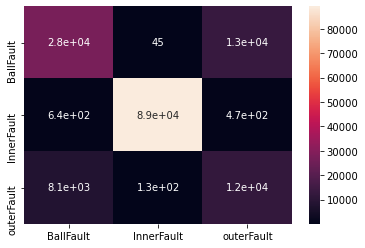

In [44]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred_list)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True)

In [45]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.76      0.68      0.71     40783
           1       1.00      0.99      0.99     90346
           2       0.47      0.60      0.53     20383

    accuracy                           0.85    151512
   macro avg       0.74      0.75      0.74    151512
weighted avg       0.86      0.85      0.86    151512

